In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
import numpy as np
import tensorflow as tf
import keras.metrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scipy import ndimage

Using TensorFlow backend.


In [0]:
class ParticleClassifier():
    def __init__(self):
        '''x and y is after preprocessing'''
        self.path = None
        self.images = None
        self.labels = None
        self.images_train = None
        self.images_test = None
        self.labels_train = None
        self.labels_test = None
        self.x = None
        self.y = None
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None
        self.images_attacked = None
        self.labels_attacked = None
        self.x_attacked = None
        self.y_attacked = None
        self.predictions = None
        self.attacked_predictions = None
        self.images_set = [self.images_train, self.images_test, self.images_attacked]
        self.x_set = [self.x_train, self.x_test, self.x_attacked]
        self.labels_set = [self.labels_train, self.labels_test]
        
        self.model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 50x50 with 1 bytes color
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(50, 50, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
        ])
        
        self.messages = {'load_data': 'Data loaded into self.images, self.labels',
                         'train_test_split': 'Split into self.images_train, self.images_test, self.labels_train, self.labels_test',
                         'pre_proc_train': 'Train images pre-processed into self.x_train',
                         'pre_proc_test': 'Test images pre-processed into self.x_test',
                         'one_hot_encode': 'Train and test labels encoded into self.y_train and self.y_test',
                         'train_model': 'Model trained.',
                         'gen_hot_channel_data': 'Hot channel data generated in self.images_attacked, self.labels_attacked, self.x_attacked, self.y_attacked'}
            
        
    def __call__(self):
        return
        
    def load_data(self, path='toy_data.csv'):
        '''Loads data from path into self.labels and self.images'''
        self.path = path
        data = np.genfromtxt(path, delimiter=',')
        self.labels = data[:,0].astype(int)
        self.images = data[:, 1:].reshape((len(data),50,50,1))
        print(self.messages['load_data'])
        return self
    
    def train_test_split(self, images=None, labels=None, test_size=0.2):
        '''Wrapper around train_test_split'''
        if images is None:
            images = self.images
        if labels is None:
            labels = self.labels
        self.images_train, self.images_test, self.labels_train, self.labels_test = \
        train_test_split(images, labels, test_size=test_size)
        print(self.messages['train_test_split'])
        return self
        
    def pre_proc_filter(self, images, size=2, sigma=2):
        '''Applies Median filter and Gaussian filter to remove noise and hot
        channels. Size refers to size of Median filter, sigma refers to Gaussian
        filter parameter - larger for more blurring.
        Parameters
        ----------
        size: int, optional 
        sigma: int, optional
        '''
        orig_shape = images.shape
        images_new = []
        for image in images.reshape((images.shape[0:-1])):        
            image_new = ndimage.median_filter(image, size=size, mode='wrap')
            image_new = ndimage.gaussian_filter(image_new, sigma=sigma)
            images_new.append(image_new)
        return np.array(images_new).reshape(orig_shape)
    
    def pre_proc_rescale(self, images, negative=False):
        '''Subtract the mean, scales all image to between -1 and 1, and remove
        all negative values (if False).
        '''
        orig_shape = images.shape
        images_reshaped = images.reshape((orig_shape[0], -1))
        images_scaled = np.subtract(images_reshaped, np.median(images_reshaped, axis=1, keepdims=True))
        if not negative:
            images_scaled[images_scaled < 0] = 0.
        images_scaled = np.divide(images_scaled, np.max(images_scaled, axis=1, keepdims=True))
        images_scaled = images_scaled.reshape(orig_shape)
        return images_scaled
    
    def pre_proc(self, images, size=2, sigma=2, filters=False, rescale=True):
        '''Helper function that removes applies pre-processing to givem images.
        '''
        x = images.copy()
        if filter:
            x = self.pre_proc_filter(x, size=size, sigma=sigma)
        if rescale:
            x = self.pre_proc_rescale(x)
        return x
    
    def pre_proc_images(self, filters=False, rescale=True, 
                        train=False, test=False, attacked=False, size=2, sigma=2):
        '''Pre-processes any of the 3 image sets (train, test, attacked).
        Filters indicate if Median and Gaussian filters should be applied. 
        Rescale indicate if images should be rescaled.'''
        if train:
            self.x_train = self.pre_proc(self.images_train, size=size, 
                                         sigma=sigma, filters=filters, 
                                         rescale=rescale)
        if test:
            self.x_test = self.pre_proc(self.images_test, size=size, sigma=sigma,
                                        filters=filters, rescale=rescale)
        if attacked:
            self.x_attacked = self.pre_proc(self.images_attacked, size=size,
                                            sigma=sigma, filters=filters, 
                                            rescale=rescale)
        return self
    
    def one_hot_encode_labels(self, train=False, test=False, attacked=False):
        '''One hot encodes any of the 3 label sets (train, test, attacked).'''
        if train:
            self.y_train = to_categorical(self.labels_train)
        if test:
            self.y_test = to_categorical(self.labels_test)
        if attacked:
            self.y_attacked = to_categorical(self.labels_attacked)
        print(self.messages['one_hot_encode'])
        return self

        
    def train_model(self, x=None, y=None, val_split=0.2, epochs=10, verbose=1,
                    callback=None, min_delta=0.2, patience=5):
        '''Trains CNN model.'''
        if x is None:
            x = self.x_train
        if y is None:
            y = self.y_train
        if callback is None:
            self.callback = EarlyStopping(monitor='val_acc',
                                      min_delta=min_delta,
                                      patience=patience)
            
        self.model.compile(loss='categorical_crossentropy',
                          optimizer='adam',
                          metrics=['acc'])
        
        self.model.fit(x,
                      y,  
                      epochs=epochs,
                      verbose=verbose,
                      validation_split=val_split,
                      callbacks=[self.callback])
        print(self.messages['train_model'])
        return self
    
    def evaluate_model(self, x_test=None, y_test=None):
        '''Evaluate model against test set'''
        if x_test is None:
            x_test = self.x_test
        if y_test is None:
            y_test = self.y_test
        self.model.evaluate(x_test, y_test)
        y_pred = self.model.predict(x_test)
        print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
        return self
    
    def gen_hot_channel_data(self, images=None, labels=None, value=None):
        '''Adds a hot channel with double the max value at a random location 
        for each image.'''
        change_self = False
        if images is None:
            images = self.images_test
            change_self = True
        if labels is None:
            labels = self.labels_test
        if value is None:
            value = np.max(images) * 2
        loc = np.random.randint(0, images.shape[2], size=(images.shape[0], 2))
        images_edited = images.copy()
        images_edited[np.arange(images.shape[0]),loc[:,0], loc[:,1]] = value
        self.images_attacked = images_edited
        self.x_attacked = self.pre_proc(self.images_attacked)
        self.labels_attacked = labels
        self.y_attacked = self.one_hot_encode_labels(labels)
        print(self.messages['gen_hot_channel_data'])
        return self
    
    def evaluate_attack(self, x=None, x_attacked=None, labels=None):
        '''Evaluates the 
        against predictions without attack. Test data is used by default'''
        if x is None:
            x = self.x_test
            x_attacked = self.x_attacked
            labels_attacked = self.labels_attacked
        original_pred = np.argmax(self.model.predict(x), axis=1).astype(int)
        attacked_pred = np.argmax(self.model.predict(x_attacked), axis=1).astype(int)
        self.predictions = original_pred
        self.attacked_predictions = attacked_pred
        print('Labels: {} \n Original Predictions: {} \n Attacked Predictions: {}'\
              .format(np.bincount(labels_attacked), np.bincount(original_pred), np.bincount(attacked_pred)))
        print(classification_report(original_pred, attacked_pred)) 
        return self
    
    def apply_attack(self, attack, images=None, labels=None, **kwargs):
        '''Update images_attacked and labels_attacked after applying attack
        on an image set (test by default). '''
        if images is None:
            images = self.images_test
        if labels is None:
            labels = self.labels_test
        images_edited = images.copy()
        images_edited = attack(images, **kwargs)
        
        self.images_attacked = images_edited
        self.labels_attacked = labels
        return self
        
    def add_hot_area(self, images, size, value=None, pos=None):
        '''Adds a hot channel at a given location pos=(x, y) with 
        size (i, j) for a given image.
        :param images (n, x, y, 1)
        :param pos (x, y), x and y are arrays of length n
        :param size (i, j)
        :param value to be replaced'''
        if pos is None:
            x = np.random.randint(0, images.shape[1]-size[0],
                                  size=(images.shape[0],1))
            y = np.random.randint(0, images.shape[2]-size[1], 
                                  size=(images.shape[0], 1))
            pos = np.concatenate([x, y], axis=1)
        if value is None:
            value = images.max()
        for i in range(size[0]):
            for j in range(size[1]):
                images[np.arange(images.shape[0]), pos[:,0]+i, pos[:,1]+j, 0] = value
        return images
    
    def hot_pixel_attack(self, images=None, labels=None, value=None):
        if images is None:
            images = self.images_test
        if labels is None:
            labels = self.labels_test
        if value is None:
            value = np.max(images) * 2
            
        loc = np.random.randint(0, images.shape[2], size=(images.shape[0], 2))
        self.apply_attack(self.add_hot_area, images, labels, 
                          size=[1,1], value=value, pos=loc)
        return self

    def add_gaussian_noise(self, images, mu, sigma):
        '''Adds Gaussian noise for a given image, with mean = mu and standard
        deviation = sigma.
        :param images (n, x, y, 1)
        :param mu float
        :param sigma float'''
        gauss = np.random.normal(mu, sigma, size=images.shape)
        images = images + gauss
        return images

    def add_sp_noise(self, images, ratio, prob):
        '''Adds salt & pepper noise for a given image, with a ratio between salt
        and pepper = ratio, and probability of noise = prob
        :param images (n, x, y, 1)
        :param ratio float
        :param prob float'''
        salt = np.ceil(prob * ratio * images[0].size)
        pepper = np.ceil(prob * (1-ratio) * images[0].size)

        for i in range(int(salt)):
          loc = np.random.randint(0, images.shape[2], size=(images.shape[0], 2))
          images[np.arange(images.shape[0]),loc[:,0], loc[:,1]] = images.max()
          
        for j in range(int(pepper)):
          loc = np.random.randint(0, images.shape[2], size=(images.shape[0], 2))
          images[np.arange(images.shape[0]),loc[:,0], loc[:,1]] = 0
        return images
        
    def print_image(self, index, image_set):
        '''Shows the nth image of an 4d image set of n images: (n, height, length, channel)'''
        plt.imshow(image_set[index,:,:,0])
        plt.show()

In [21]:
classifier = ParticleClassifier()\
                .load_data('toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 9s 4ms/sample - loss: 0.5878 - acc: 0.7120 - val_loss: 0.2670 - val_acc: 0.9146
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1988 - acc: 0.9276 - val_loss: 0.2376 - val_acc: 0.9333
Epoch 3/10
1920/1920 [==============================] - 9s 4ms/sample - loss: 0.1768 - acc: 0.9333 - val_loss: 0.1903 - val_acc: 0.9333
Epoch 4/10
1920/1920 [==============================] - 9s 5ms/sample - loss: 0.1270 - acc: 0.9552 - val_loss: 0.1910 - val_acc: 0.9396
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1507 - acc: 0.9474 - val_loss: 0.2559 - val_acc: 0.9000
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.117

Gaussian noise

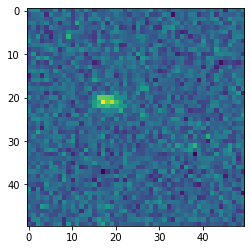

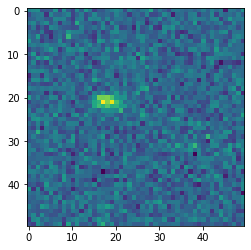

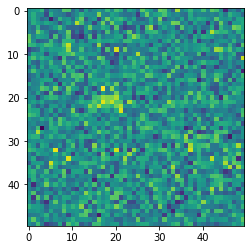

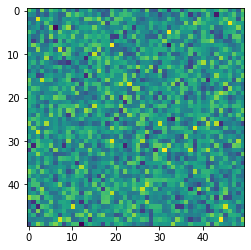

In [17]:
images = classifier.images
plt.imshow(images[0,:,:,0])
plt.show()
for i in [1, 10, 100]:
    gauss = np.random.normal(0, i, size=images.shape)
    noisy = images + gauss
    plt.imshow(noisy[0,:,:,0])
    plt.show()

In [82]:
mu = 0
sigma = 1
classifier = ParticleClassifier()\
                .load_data('toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.add_gaussian_noise, mu=mu, sigma=sigma)\
               .pre_proc_images(attacked=True, filters=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 9s 5ms/sample - loss: 0.5389 - acc: 0.7458 - val_loss: 0.2623 - val_acc: 0.8708
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2379 - acc: 0.9068 - val_loss: 0.2317 - val_acc: 0.9083
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1795 - acc: 0.9396 - val_loss: 0.1724 - val_acc: 0.9292
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1639 - acc: 0.9391 - val_loss: 0.1525 - val_acc: 0.9354
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2052 - acc: 0.9208 - val_loss: 0.1786 - val_acc: 0.9208
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.143

In [83]:
mu = 0
sigma = 10
classifier = ParticleClassifier()\
                .load_data('toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.add_gaussian_noise, mu=mu, sigma=sigma)\
               .pre_proc_images(attacked=True, filters=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 9s 5ms/sample - loss: 0.5585 - acc: 0.7474 - val_loss: 0.2448 - val_acc: 0.9104
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1988 - acc: 0.9234 - val_loss: 0.1523 - val_acc: 0.9479
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1698 - acc: 0.9438 - val_loss: 0.1601 - val_acc: 0.9375
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1553 - acc: 0.9500 - val_loss: 0.1231 - val_acc: 0.9604
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1451 - acc: 0.9484 - val_loss: 0.1222 - val_acc: 0.9667
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.117

In [84]:
mu = 0
sigma = 100
classifier = ParticleClassifier()\
                .load_data('toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.add_gaussian_noise, mu=mu, sigma=sigma)\
               .pre_proc_images(attacked=True, filters=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 9s 4ms/sample - loss: 0.5166 - acc: 0.7750 - val_loss: 0.2222 - val_acc: 0.9104
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1861 - acc: 0.9370 - val_loss: 0.1631 - val_acc: 0.9375
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1706 - acc: 0.9417 - val_loss: 0.1408 - val_acc: 0.9375
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1579 - acc: 0.9406 - val_loss: 0.1542 - val_acc: 0.9458
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1225 - acc: 0.9568 - val_loss: 0.1189 - val_acc: 0.9500
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.116

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Salt & pepper noise

In [133]:
ratio = 0.5
prob = 0.0001
classifier = ParticleClassifier()\
                .load_data('toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.add_sp_noise, ratio=ratio, prob=prob)\
               .pre_proc_images(attacked=True, filters=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 9s 5ms/sample - loss: 0.5220 - acc: 0.7833 - val_loss: 0.2142 - val_acc: 0.9208
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2140 - acc: 0.9167 - val_loss: 0.1830 - val_acc: 0.9375
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1865 - acc: 0.9354 - val_loss: 0.1209 - val_acc: 0.9604
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1380 - acc: 0.9505 - val_loss: 0.1298 - val_acc: 0.9583
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1306 - acc: 0.9552 - val_loss: 0.1375 - val_acc: 0.9583
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.120

In [135]:
ratio = 0.5
prob = 0.01
classifier = ParticleClassifier()\
                .load_data('toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.add_sp_noise, ratio=ratio, prob=prob)\
               .pre_proc_images(attacked=True, filters=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 9s 5ms/sample - loss: 0.5233 - acc: 0.7885 - val_loss: 0.2912 - val_acc: 0.8833
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2050 - acc: 0.9224 - val_loss: 0.2832 - val_acc: 0.9125
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1687 - acc: 0.9391 - val_loss: 0.2436 - val_acc: 0.9062
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2038 - acc: 0.9234 - val_loss: 0.1897 - val_acc: 0.9417
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1227 - acc: 0.9583 - val_loss: 0.1388 - val_acc: 0.9625
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.102

In [141]:
ratio = 0.5
prob = 0.1
classifier = ParticleClassifier()\
                .load_data('toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.add_sp_noise, ratio=ratio, prob=prob)\
               .pre_proc_images(attacked=True, filters=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 9s 5ms/sample - loss: 0.5317 - acc: 0.7578 - val_loss: 0.3392 - val_acc: 0.8604
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2296 - acc: 0.9104 - val_loss: 0.2446 - val_acc: 0.9021
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1826 - acc: 0.9302 - val_loss: 0.2463 - val_acc: 0.9083
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1511 - acc: 0.9370 - val_loss: 0.2187 - val_acc: 0.9229
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1315 - acc: 0.9521 - val_loss: 0.1771 - val_acc: 0.9396
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.130

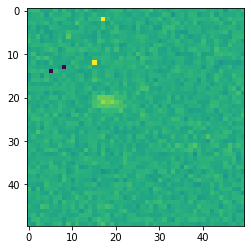

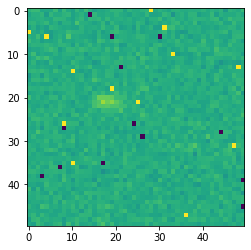

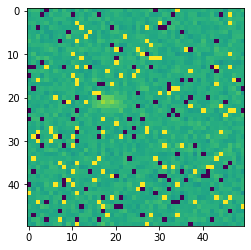

In [22]:
images = classifier.images
for i in [0.001, 0.01, 0.1]:
  ratio = 0.5
  prob = i
  sp_test = np.copy(images)
  salt = np.ceil(prob * ratio * images[0].size)
  pepper = np.ceil(prob * (1-ratio) * images[0].size)

  for i in range(int(salt)):
    loc = np.random.randint(0, images.shape[2], size=(images.shape[0], 2))
    sp_test[np.arange(images.shape[0]),loc[:,0], loc[:,1]] = images.max()
    
  for j in range(int(pepper)):
    loc = np.random.randint(0, images.shape[2], size=(images.shape[0], 2))
    sp_test[np.arange(images.shape[0]),loc[:,0], loc[:,1]] = 0

  plt.imshow(sp_test[0,:,:,0])
  plt.show()

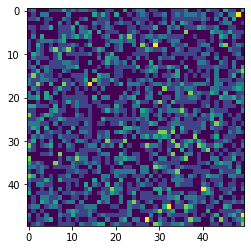

In [13]:
images = classifier.images
poisson = np.random.poisson(1, size=images.shape)
plt.imshow(poisson[0,:,:,0])